In [1]:
import os
PATH = '/home/azureuser/lmassera/'

In [2]:
import pickle

with open(os.path.join(PATH, 'data/training_hl_inp.pickle'), 'rb') as f:
    training_data_inp = pickle.load(f)
with open(os.path.join(PATH, 'data/training_hl_trg.pickle'), 'rb') as f:
    training_data_trg = pickle.load(f)

In [ ]:
with open('/Users/luca/Data/waldo/deep_muons/testing_hl_inp.pickle', 'rb') as f:
    observations_inp = pickle.load(f)
with open('/Users/luca/Data/waldo/deep_muons/testing_hl_trg.pickle', 'rb') as f:
    observations_trg = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/home/azureuser/lmassera/data/testing_hl_inp.pickle'

### DIVIDE in B_SAMPLE and B_PRIME_SAMPLE

In [4]:
n_train_cutoffs = 200_000

In [5]:
b_sample_theta, b_sample_x = training_data_trg[:-n_train_cutoffs], training_data_inp[:-n_train_cutoffs, :]
b_sample_theta.shape, b_sample_x.shape

((662085,), (662085, 28))

In [6]:
b_prime_sample_theta, b_prime_sample_x = training_data_trg[-n_train_cutoffs:], training_data_inp[-n_train_cutoffs:, :]
b_prime_sample_theta.shape, b_prime_sample_x.shape

((200000,), (200000, 28))

### STATISTICS

In [7]:
# from lightgbm import LGBMRegressor
# from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import os
import numpy as np

#### ESTIMATE CONDITIONAL MEAN

##### RF

In [8]:
conditional_mean = RandomForestRegressor(n_estimators=200, n_jobs=-1, max_features=0.3)

In [69]:
rmse_scores = -1*cross_val_score(estimator=conditional_mean, X=b_sample_x, y=b_sample_theta, scoring="neg_root_mean_squared_error", 
                                 cv=5, n_jobs=-1, verbose=1)
print("5-fold CV RMSE: ", np.mean(rmse_scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


5-fold CV RMSE:  1534.7865331577348


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.8min finished


In [9]:
conditional_mean.fit(X=b_sample_x, y=b_sample_theta)
cond_mean_preds = conditional_mean.predict(X=b_sample_x)

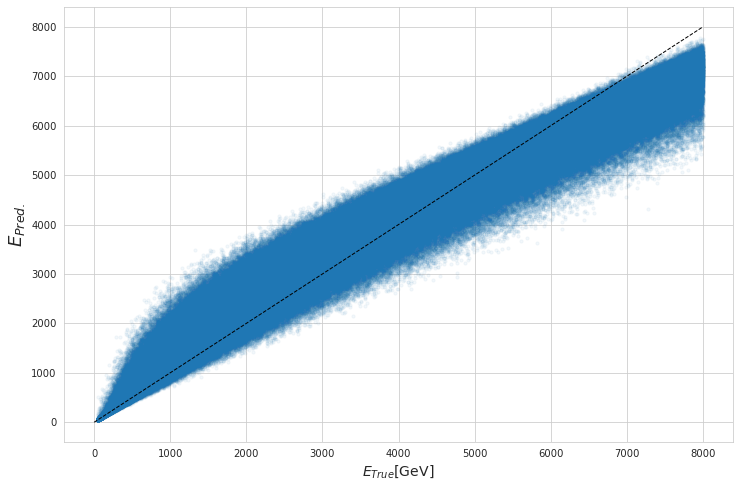

In [10]:
plt.figure(figsize=(12, 8))

plt.scatter(b_sample_theta, cond_mean_preds, s=10, alpha=0.05)
plt.plot([0, 8000], [0, 8000], linestyle='--', linewidth=1, color='black')
plt.xlabel(r'$E_{True}$[GeV]', fontsize=14)
plt.ylabel(r'$E_{Pred.}$', fontsize=18)
plt.show()

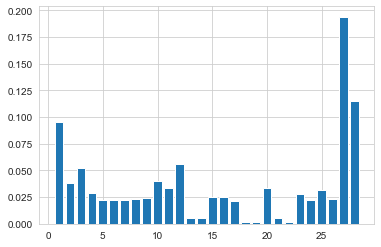

In [9]:
plt.bar(x=range(1,29), height=conditional_mean.feature_importances_)
plt.show()

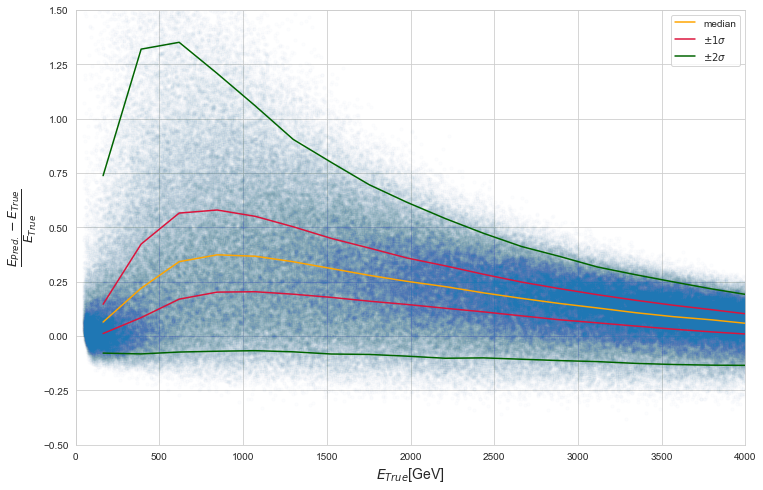

In [10]:
plt.figure(figsize=(12, 8))

frac_err = (conditional_mean.predict(X=b_sample_x) - b_sample_theta)/b_sample_theta
plt.scatter(b_sample_theta, frac_err, alpha=0.01, s=10)

bins = np.linspace(50, 8000, 36)
plt.plot([(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)], 
         [np.median(frac_err[(b_sample_theta < bins[i+1]) & (b_sample_theta >= bins[i])]) for i in range(len(bins)-1)], color='orange', label='median')
plt.plot([(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)], 
         [np.quantile(frac_err[(b_sample_theta < bins[i+1]) & (b_sample_theta >= bins[i])], q=0.683) for i in range(len(bins)-1)], color='crimson', label=r'$\pm 1 \sigma$')
plt.plot([(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)], 
         [np.quantile(frac_err[(b_sample_theta < bins[i+1]) & (b_sample_theta >= bins[i])], q=0.317) for i in range(len(bins)-1)], color='crimson')
plt.plot([(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)], 
         [np.quantile(frac_err[(b_sample_theta < bins[i+1]) & (b_sample_theta >= bins[i])], q=0.9545) for i in range(len(bins)-1)], color='darkgreen', label=r'$\pm 2 \sigma$')
plt.plot([(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)], 
         [np.quantile(frac_err[(b_sample_theta < bins[i+1]) & (b_sample_theta >= bins[i])], q=0.0455) for i in range(len(bins)-1)], color='darkgreen')

plt.xlim(left=0, right=4000)
plt.ylim(bottom=-0.5, top=1.5)
plt.xlabel(r'$E_{True}$[GeV]', fontsize=14)
plt.ylabel(r'$\frac{E_{Pred.}-E_{True}}{E_{True}}$', fontsize=18)
plt.legend()
plt.show()

##### XGB

In [ ]:
conditional_mean = XGBRegressor(objective='reg:squarederror', verbosity=1, tree_method="hist", 
                                max_depth=3, reg_lambda=0.7, n_estimators=1000, learning_rate=0.2)
rmse_scores = -1*cross_val_score(estimator=conditional_mean, X=b_sample_x, y=b_sample_theta, scoring="neg_root_mean_squared_error", 
                                 cv=5, n_jobs=-1, verbose=1)
print("5-fold CV RMSE: ", np.mean(rmse_scores))

In [64]:
conditional_mean = XGBRegressor(objective='reg:squarederror', verbosity=1, tree_method="hist", 
                                max_depth=3, reg_lambda=0.7, n_estimators=1000, learning_rate=0.2)
rmse_scores = -1*cross_val_score(estimator=conditional_mean, X=b_sample_x, y=b_sample_theta, scoring="neg_root_mean_squared_error", 
                                 cv=5, n_jobs=-1, verbose=1)
print("5-fold CV RMSE: ", np.mean(rmse_scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


5-fold CV RMSE:  1523.825244140625


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


In [65]:
conditional_mean.fit(X=b_sample_x, y=b_sample_theta)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=10,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=0.7, scale_pos_weight=1, subsample=1,
             tree_method='hist', validate_parameters=1, verbosity=1)

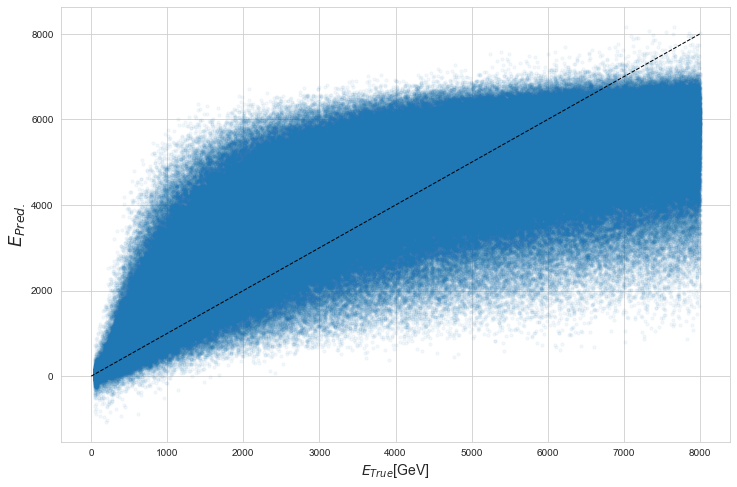

In [66]:
plt.figure(figsize=(12, 8))

plt.scatter(b_sample_theta, conditional_mean.predict(X=b_sample_x), s=10, alpha=0.05)
plt.plot([0, 8000], [0, 8000], linestyle='--', linewidth=1, color='black')
plt.xlabel(r'$E_{True}$[GeV]', fontsize=14)
plt.ylabel(r'$E_{Pred.}$', fontsize=18)
plt.show()

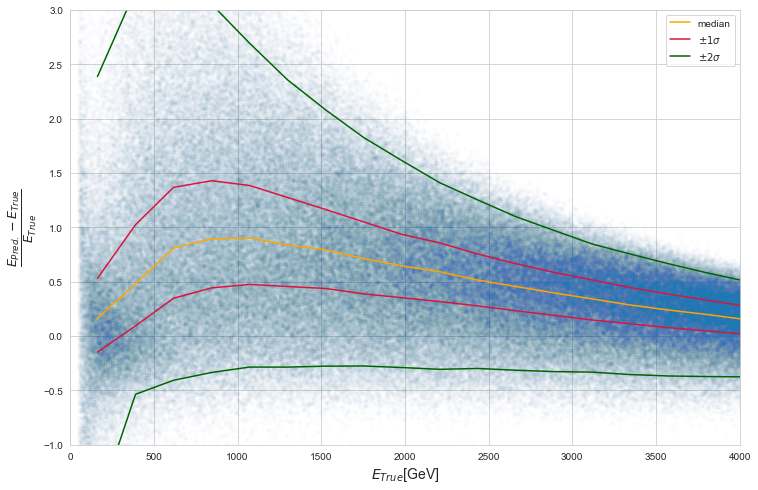

In [45]:
plt.figure(figsize=(12, 8))

frac_err = (conditional_mean.predict(X=b_sample_x) - b_sample_theta)/b_sample_theta
plt.scatter(b_sample_theta, frac_err, alpha=0.01, s=10)

bins = np.linspace(50, 8000, 36)
plt.plot([(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)], 
         [np.median(frac_err[(b_sample_theta < bins[i+1]) & (b_sample_theta >= bins[i])]) for i in range(len(bins)-1)], color='orange', label='median')
plt.plot([(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)], 
         [np.quantile(frac_err[(b_sample_theta < bins[i+1]) & (b_sample_theta >= bins[i])], q=0.683) for i in range(len(bins)-1)], color='crimson', label=r'$\pm 1 \sigma$')
plt.plot([(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)], 
         [np.quantile(frac_err[(b_sample_theta < bins[i+1]) & (b_sample_theta >= bins[i])], q=0.317) for i in range(len(bins)-1)], color='crimson')
plt.plot([(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)], 
         [np.quantile(frac_err[(b_sample_theta < bins[i+1]) & (b_sample_theta >= bins[i])], q=0.9545) for i in range(len(bins)-1)], color='darkgreen', label=r'$\pm 2 \sigma$')
plt.plot([(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)], 
         [np.quantile(frac_err[(b_sample_theta < bins[i+1]) & (b_sample_theta >= bins[i])], q=0.0455) for i in range(len(bins)-1)], color='darkgreen')

plt.xlim(left=0, right=4000)
plt.ylim(bottom=-1, top=3)
plt.xlabel(r'$E_{True}$[GeV]', fontsize=14)
plt.ylabel(r'$\frac{E_{Pred.}-E_{True}}{E_{True}}$', fontsize=18)
plt.legend()
plt.show()

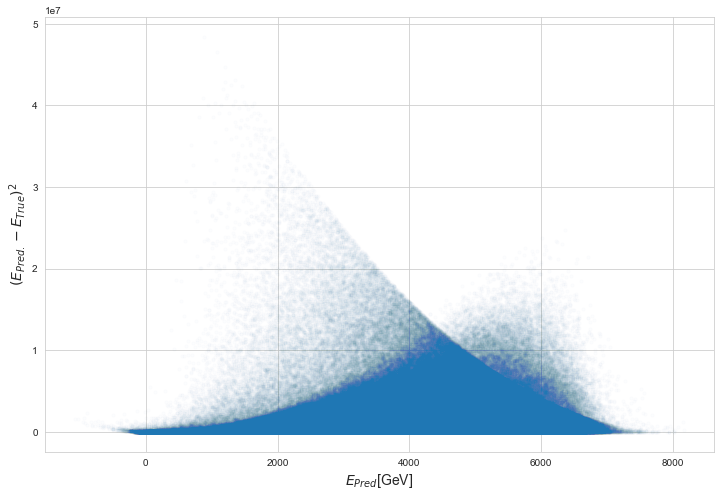

In [46]:
plt.figure(figsize=(12, 8))

preds = conditional_mean.predict(X=b_sample_x) 
plt.scatter(preds, (preds - b_sample_theta)**2, alpha=0.01, s=10)
plt.xlabel(r'$E_{Pred}$[GeV]', fontsize=14)
plt.ylabel(r'$(E_{Pred.}-E_{True})^2$', fontsize=14)
plt.show()

#### ESTIMATE CONDITIONAL VARIANCE

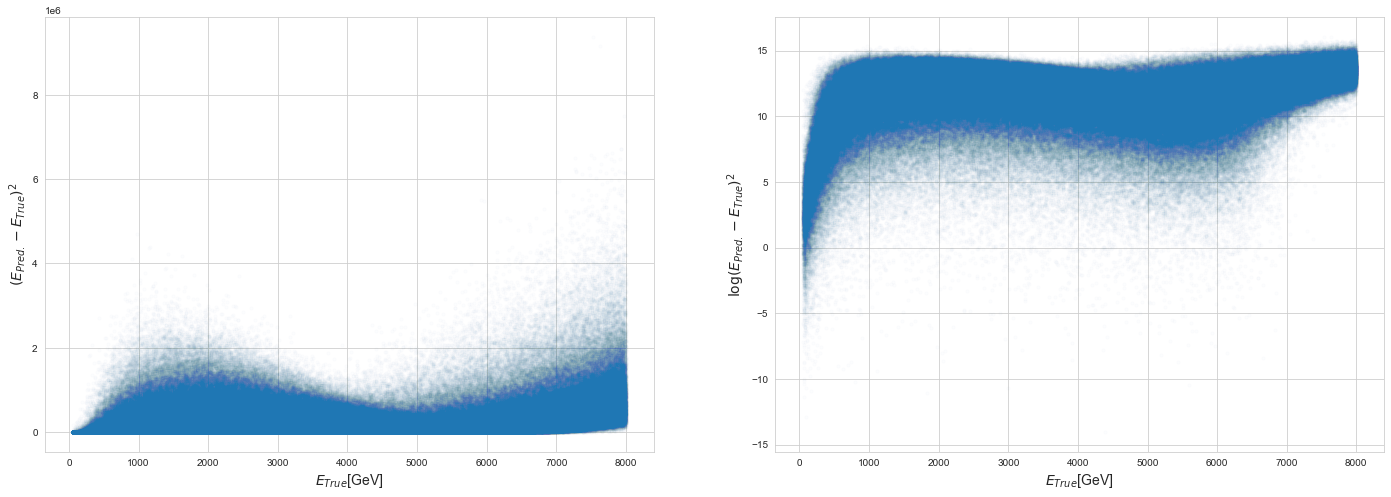

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))

ax[0].scatter(b_sample_theta, (preds - b_sample_theta)**2, alpha=0.01, s=10)
ax[0].set_xlabel(r'$E_{True}$[GeV]', fontsize=14)
ax[0].set_ylabel(r'$(E_{Pred.}-E_{True})^2$', fontsize=14)

ax[1].scatter(b_sample_theta, np.log((preds - b_sample_theta)**2), alpha=0.01, s=10)
ax[1].set_xlabel(r'$E_{True}$[GeV]', fontsize=14)
ax[1].set_ylabel(r'$\log(E_{Pred.}-E_{True})^2$', fontsize=14)

plt.show()

##### VAR

In [8]:
cond_var_response = ((b_sample_theta.reshape(-1,1) - conditional_mean.predict(X=b_sample_x).reshape(-1, 1))**2).reshape(-1,)
assert cond_var_response.shape == (b_sample_theta.shape[0],), cond_var_response.shape

In [9]:
conditional_var = RandomForestRegressor(n_estimators=200, n_jobs=-1, max_features=0.3)
conditional_var.fit(X=b_sample_x, y=cond_var_response)

RandomForestRegressor(max_features=0.3, n_estimators=200, n_jobs=-1)

In [10]:
var_preds = conditional_var.predict(X=b_sample_x)
var_preds[var_preds <= 0] = 1e-6

##### LOGVAR

In [11]:
log_cond_var_response = np.log(((b_sample_theta.reshape(-1,1) - conditional_mean.predict(X=b_sample_x).reshape(-1, 1))**2)).reshape(-1,)
assert log_cond_var_response.shape == (b_sample_theta.shape[0],), log_cond_var_response.shape

In [12]:
log_conditional_var = RandomForestRegressor(n_estimators=200, n_jobs=-1, max_features=0.3)
log_conditional_var.fit(X=b_sample_x, y=log_cond_var_response)
log_var_preds = log_conditional_var.predict(X=b_sample_x)

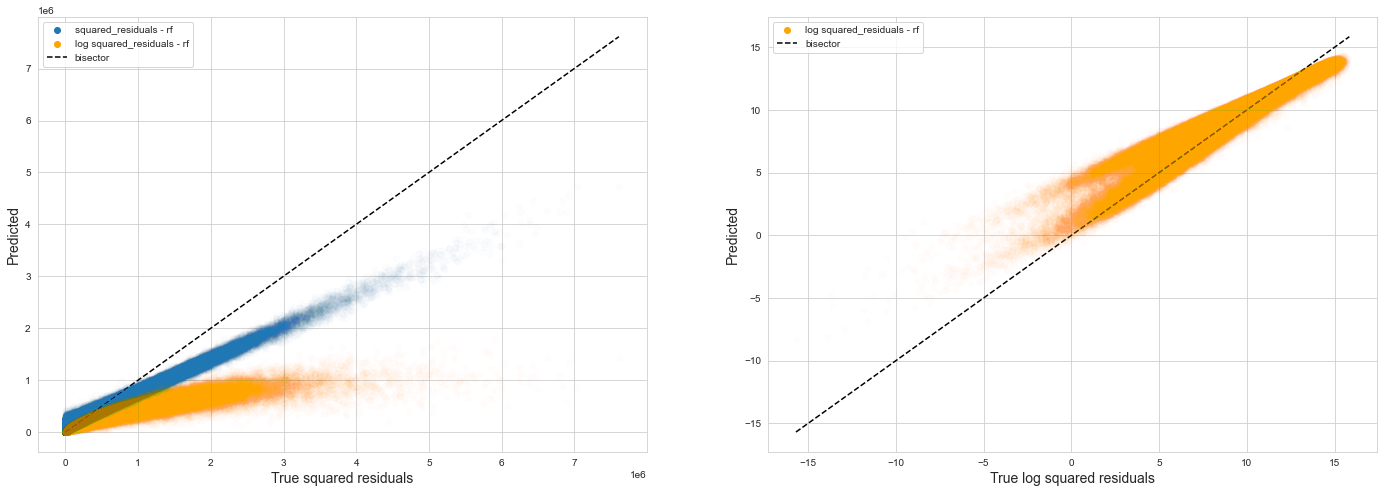

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))

ax[0].scatter(cond_var_response, var_preds, alpha=0.01, zorder=5, label='squared_residuals - rf')
ax[0].scatter(np.exp(log_cond_var_response), np.exp(log_var_preds), alpha=0.01, zorder=5, label='log squared_residuals - rf', color='orange')
min_xy = np.min([np.min(cond_var_response), np.min(var_preds)])
max_xy = np.max([np.max(cond_var_response), np.max(var_preds)])
ax[0].plot([min_xy, max_xy], [min_xy, max_xy], 
             color="black", linestyle="--", label="bisector", zorder=2)
ax[0].set_xlabel('True squared residuals', fontsize=14)
ax[0].set_ylabel('Predicted', fontsize=14)
legend_0 = ax[0].legend()
for lh in legend_0.legendHandles: 
    lh.set_alpha(1)

ax[1].scatter(log_cond_var_response, log_var_preds, alpha=0.01, zorder=5, color='orange', label='log squared_residuals - rf')
min_xy = np.min([np.min(log_cond_var_response), np.min(log_var_preds)])
max_xy = np.max([np.max(log_cond_var_response), np.max(log_var_preds)])
ax[1].plot([min_xy, max_xy], [min_xy, max_xy], 
             color="black", linestyle="--", label="bisector", zorder=2)
ax[1].set_xlabel('True log squared residuals', fontsize=14)
ax[1].set_ylabel('Predicted', fontsize=14)
legend_1 = ax[1].legend()
for lh in legend_1.legendHandles: 
    lh.set_alpha(1)

plt.show()

##### VAR WITH LINEAR CORRECTION

In [11]:
sample_size_correction = 10_000
correction_mask = np.zeros(len(b_sample_theta), dtype=bool)
correction_mask[np.random.choice(range(len(b_sample_theta)), replace=False, size=sample_size_correction)] = True
corr_b_sample_theta, corr_b_sample_x = b_sample_theta[np.logical_not(correction_mask)], b_sample_x[np.logical_not(correction_mask), :]
correction_sample_theta, correction_sample_x = b_sample_theta[correction_mask], b_sample_x[correction_mask, :]

corr_b_sample_theta.shape, corr_b_sample_x.shape, correction_sample_theta.shape, correction_sample_x.shape

((652085,), (652085, 28), (10000,), (10000, 28))

In [12]:
corr_cond_var_response = ((corr_b_sample_theta.reshape(-1,1) - conditional_mean.predict(X=corr_b_sample_x).reshape(-1, 1))**2).reshape(-1,)
assert corr_cond_var_response.shape == (corr_b_sample_theta.shape[0],), corr_cond_var_response.shape

In [13]:
corr_conditional_var = RandomForestRegressor(n_estimators=200, n_jobs=-1, max_features=0.3)
corr_conditional_var.fit(X=corr_b_sample_x, y=corr_cond_var_response)

RandomForestRegressor(max_features=0.3, n_estimators=200, n_jobs=-1)

Extract linear correction coefficients

In [90]:
def correction_coeffs(true, predicted, intercept=False, sklearn=False):
    if not sklearn:
        if intercept:
            X = np.hstack((
                np.ones(shape=(len(true), 1)),
                true.reshape(-1, 1)
            ))
        else:
            X = true.reshape(-1, 1)
        y = predicted.reshape(-1, 1)
        beta = np.linalg.inv(X.T @ X) @ X.T @ y
        assert beta.shape == (X.shape[1], 1), beta.shape
        return beta.reshape(-1, )
    else:
        from sklearn.linear_model import LinearRegression
        linreg = LinearRegression(fit_intercept=intercept)
        linreg.fit(X=true.reshape(-1, 1), y=predicted)
        return np.concatenate((np.array([linreg.intercept_]), linreg.coef_))

def invert_fit(beta, predicted, intercept=False):
    print('inverting')
    if intercept:
        return (predicted-beta[0])/beta[1]
    else:
        return predicted/beta.reshape(-1, )[0]

In [91]:
beta = correction_coeffs(true=((correction_sample_theta.reshape(-1,1) - conditional_mean.predict(X=correction_sample_x).reshape(-1, 1))**2).reshape(-1,), 
                         predicted=corr_conditional_var.predict(X=correction_sample_x), intercept=False, sklearn=True)
beta

array([0.        , 0.42702709])

In [92]:
corr_var_preds = invert_fit(beta, corr_conditional_var.predict(X=corr_b_sample_x))
corr_var_preds.shape

inverting


/var/folders/cr/nrr0gxg51qx4vsp_ckd6nly00000gn/T/ipykernel_8126/858884148.py:25: RuntimeWarning: divide by zero encountered in true_divide
  return predicted/beta.reshape(-1, )[0]


(652085,)

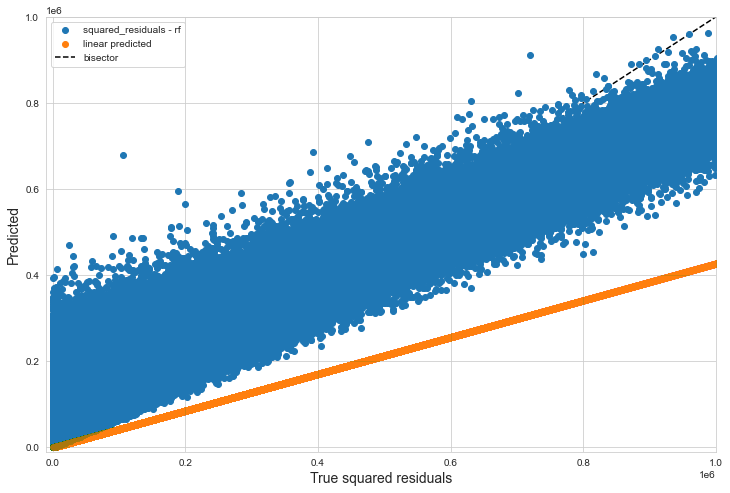

In [93]:
fig, ax = plt.subplots(1, figsize=(12, 8))

ax.scatter(cond_var_response, var_preds, alpha=1, zorder=5, label='squared_residuals - rf')
#ax.scatter(corr_cond_var_response, corr_var_preds, alpha=0.01, zorder=5, label='squared_residuals - rf - corrected')
ax.scatter(corr_cond_var_response, beta[0] + corr_cond_var_response*beta[1], alpha=0.01, zorder=5, label='linear predicted')
min_xy = np.min([np.min(cond_var_response), np.min(var_preds)])
max_xy = np.max([np.max(cond_var_response), np.max(var_preds)])
ax.plot([min_xy, max_xy], [min_xy, max_xy], 
             color="black", linestyle="--", label="bisector", zorder=2)
ax.set_xlabel('True squared residuals', fontsize=14)
ax.set_ylabel('Predicted', fontsize=14)
ax.set_xlim(-10000, 1e6)
ax.set_ylim(-10000, 1e6)
legend_0 = ax.legend()
for lh in legend_0.legendHandles: 
    lh.set_alpha(1)
    
plt.show()

### CUTOFFS

In [15]:
import sys
sys.path.append("/Users/luca/Desktop/uni/cmu/ada/ACORE-LFI/acore/")

from qr_algorithms.complete_list import classifier_cde_dict
from utils.qr_functions import train_qr_algo
from miscellanea import ModelClass

model = ModelClass(d=1, observed_dims=28, 
                   param_grid_min=50, param_grid_max=5000, grid_sample_size=2000)

In [33]:
b_prime_sample_x = b_prime_sample_x[b_prime_sample_theta < 5000, :]
b_prime_sample_theta = b_prime_sample_theta[b_prime_sample_theta < 5000]

b_prime_sample_theta.shape, b_prime_sample_x.shape

((124848,), (124848, 28))

#### VAR

In [34]:
qr_conditional_means = conditional_mean.predict(b_prime_sample_x.reshape(-1, model.observed_dims))
qr_conditional_vars = conditional_var.predict(b_prime_sample_x.reshape(-1, model.observed_dims))
qr_conditional_vars[qr_conditional_vars <= 0] = 1e-6

qr_statistics = \
    ((qr_conditional_means.reshape(-1,1) - b_prime_sample_theta.reshape(-1,1))**2)/qr_conditional_vars.reshape(-1,1)
qr_statistics.shape

(124848, 1)

###### 90% CRITICAL VALUES

xgb

In [36]:
learner_kwargs = {'max_depth': 1, 'n_estimators': 1000}
qr_XGB, predicted_lfi_cutoffs_90_xgb = train_qr_algo(model_obj=model, alpha=0.90,
                                             theta_mat=b_prime_sample_theta, stats_mat=qr_statistics,
                                             algo_name='xgb', learner_kwargs=learner_kwargs, pytorch_kwargs=None,
                                             prediction_grid=model.param_grid)

nn

In [19]:
learner_kwargs = {'epochs': 500, 'batch_size': 100}
pytorch_kwargs = {'neur_shapes': (64, 32, 16)}
qr_NN, predicted_lfi_cutoffs_90_nn = train_qr_algo(model_obj=model, alpha=0.90,
                                             theta_mat=b_prime_sample_theta, stats_mat=qr_statistics,
                                             algo_name='pytorch', learner_kwargs=learner_kwargs, pytorch_kwargs=pytorch_kwargs,
                                             prediction_grid=model.param_grid)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [06:05<00:00,  1.37it/s]


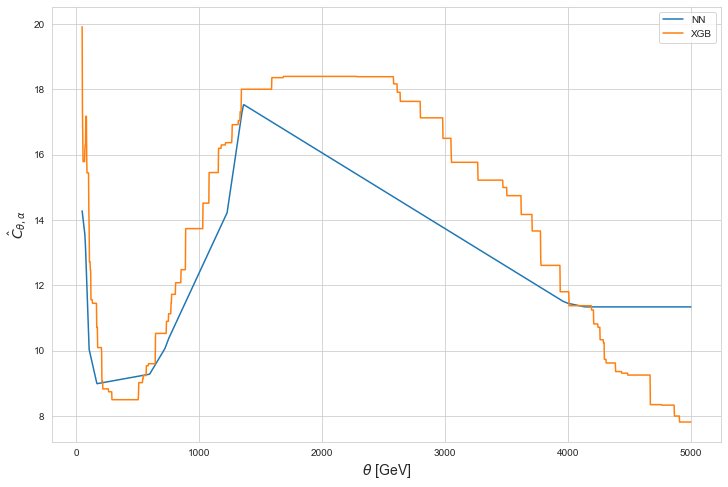

In [21]:
plt.figure(figsize=(12, 8))

plt.plot(model.param_grid, predicted_lfi_cutoffs_90_nn, label='NN')
plt.plot(model.param_grid, predicted_lfi_cutoffs_90_xgb, label='XGB')
plt.xlabel(r'$\theta$ [GeV]', fontsize=14)
plt.ylabel(r'$\hat{C}_{\theta, \alpha}$', fontsize=14)
plt.legend()
plt.show()

###### 68.3% CRITICAL VALUES

In [64]:
learner_kwargs = {'max_depth': 1, 'n_estimators': 1000}
qr_XGB_68, predicted_lfi_cutoffs_68_xgb = train_qr_algo(model_obj=model, alpha=0.683,
                                             theta_mat=b_prime_sample_theta, stats_mat=qr_statistics,
                                             algo_name='xgb', learner_kwargs=learner_kwargs, pytorch_kwargs=None,
                                             prediction_grid=model.param_grid)

#### LOGVAR

In [55]:
log_qr_conditional_vars = log_conditional_var.predict(b_prime_sample_x.reshape(-1, model.observed_dims))

log_qr_statistics = \
    ((qr_conditional_means.reshape(-1,1) - b_prime_sample_theta.reshape(-1,1))**2)/np.exp(log_qr_conditional_vars).reshape(-1,1)
log_qr_statistics.shape

(124848, 1)

###### 90% CRITICAL VALUES

xgb

In [56]:
learner_kwargs = {'max_depth': 1, 'n_estimators': 1000}
log_qr_XGB, log_predicted_lfi_cutoffs_90_xgb = train_qr_algo(model_obj=model, alpha=0.90,
                                             theta_mat=b_prime_sample_theta, stats_mat=log_qr_statistics,
                                             algo_name='xgb', learner_kwargs=learner_kwargs, pytorch_kwargs=None,
                                             prediction_grid=model.param_grid)

#### NOVAR

In [76]:
qr_conditional_means = conditional_mean.predict(b_prime_sample_x.reshape(-1, model.observed_dims))

qr_statistics_novar = (qr_conditional_means.reshape(-1,1) - b_prime_sample_theta.reshape(-1,1))**2
qr_statistics_novar.shape

(124848, 1)

90% CRITICAL VALUES

XGB

In [77]:
learner_kwargs = {'max_depth': 1, 'n_estimators': 1000}
qr_XGB_novar, predicted_lfi_cutoffs_90_xgb_novar = train_qr_algo(model_obj=model, alpha=0.90,
                                             theta_mat=b_prime_sample_theta, stats_mat=qr_statistics_novar,
                                             algo_name='xgb', learner_kwargs=learner_kwargs, pytorch_kwargs=None,
                                             prediction_grid=model.param_grid)

68.3% CRITICAL VALUES

In [83]:
learner_kwargs = {'max_depth': 1, 'n_estimators': 1000}
qr_XGB_68_novar, predicted_lfi_cutoffs_68_xgb_novar = train_qr_algo(model_obj=model, alpha=0.683,
                                             theta_mat=b_prime_sample_theta, stats_mat=qr_statistics_novar,
                                             algo_name='xgb', learner_kwargs=learner_kwargs, pytorch_kwargs=None,
                                             prediction_grid=model.param_grid)

### CONFIDENCE SETS for OBSERVATIONS

In [ ]:
predicted_cutoffs_obs_xgb = qr_XGB.predict(observations_trg.reshape(-1,1).astype(np.float32))

In [20]:
predicted_cutoffs_obs_nn = qr_NN.predict(observations_trg.reshape(-1,1).astype(np.float32))

In [22]:
from server.train_utils import plot_binned

In [23]:
obs_conditional_means = conditional_mean.predict(observations_inp.reshape(-1, model.observed_dims))
obs_conditional_vars = conditional_var.predict(observations_inp.reshape(-1, model.observed_dims))
obs_conditional_vars[obs_conditional_vars <= 0] = 1e-6

In [24]:
tile_param_grid = np.tile(model.param_grid, observations_inp.shape[0]).reshape(observations_inp.shape[0], 
                                                                               model.grid_sample_size)
observed_estimated_statistics = \
    (np.subtract(obs_conditional_means.reshape(-1,1), tile_param_grid)**2)/obs_conditional_vars.reshape(-1,1)
assert observed_estimated_statistics.shape == (observations_inp.shape[0], model.grid_sample_size), observed_estimated_statistics.shape

NN

In [25]:
waldo_confidence_sets_nn = []
for idx in range(len(observations_trg)):
    waldo_confidence_sets_nn.append(
        model.param_grid.reshape(-1,)[observed_estimated_statistics[idx, :].reshape(-1,) <= predicted_lfi_cutoffs_90_nn.reshape(-1,)]
    )

XGB

In [26]:
waldo_confidence_sets_xgb = []
for idx in range(len(observations_trg)):
    waldo_confidence_sets_xgb.append(
        model.param_grid.reshape(-1,)[observed_estimated_statistics[idx, :].reshape(-1,) <= predicted_lfi_cutoffs_90_xgb.reshape(-1,)]
    )

In [15]:
predicted_cutoffs_obs_xgb = qr_XGB.predict(observations_trg.reshape(-1,1))

------

In [28]:
observed_stats_true_param = (np.subtract(obs_conditional_means.reshape(-1,1), observations_trg.reshape(-1,1))**2)/obs_conditional_vars.reshape(-1,1)

In [29]:
plot_binned(true_params=observations_trg, confidence_sets={'WALDO_QR-xgb': waldo_confidence_sets_xgb, 
                                                           'WALDO_QR-nn': waldo_confidence_sets_nn}, 
            n_bins=13, start=50, end=5000, confidence_level=0.9, 
            coverage_diagnostics={'WALDO_QR-xgb': {'statistics': observed_stats_true_param,
                                                   'cutoffs': predicted_cutoffs_obs_xgb}, 
                                  'WALDO_QR-nn': {'statistics': observed_stats_true_param,
                                                   'cutoffs': predicted_cutoffs_obs_nn}},
            plot_length_quantiles=True, 
            custom_bin_centers=np.unique(observations_trg),
            save_fig_path='/Users/luca/Desktop/uni/cmu/research/waldo/results/calo_28HL_only/waldo_90_rf_QRnn-xgb_testing.png')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [03:18<00:00, 15.30s/it]
R[write to console]: Loading required package: nlme

R[write to console]: This is mgcv 1.8-38. For overview type 'help("mgcv-package")'.



fitting GLM
fitting GLM


### VALIDATION DATA

In [41]:
with open('/Users/luca/Data/waldo/deep_muons/validation_inp.pickle', 'rb') as f:
    validation_inp = pickle.load(f)
with open('/Users/luca/Data/waldo/deep_muons/validation_trg.pickle', 'rb') as f:
    validation_trg = pickle.load(f)

In [42]:
validation_inp = validation_inp[validation_trg < 5000, :]
validation_trg = validation_trg[validation_trg < 5000]
validation_inp.shape, validation_trg.shape

((15290, 28), (15290,))

#### VAR

In [43]:
val_conditional_means = conditional_mean.predict(validation_inp.reshape(-1, model.observed_dims))
val_conditional_vars = conditional_var.predict(validation_inp.reshape(-1, model.observed_dims))
val_conditional_vars[val_conditional_vars <= 0] = 1e-6

In [44]:
val_param_grid = np.tile(model.param_grid, validation_inp.shape[0]).reshape(validation_inp.shape[0], 
                                                                            model.grid_sample_size)
val_estimated_statistics = \
    (np.subtract(val_conditional_means.reshape(-1,1), val_param_grid)**2)/val_conditional_vars.reshape(-1,1)
assert val_estimated_statistics.shape == (validation_inp.shape[0], model.grid_sample_size), val_estimated_statistics.shape

In [45]:
val_stats_true_param = (np.subtract(val_conditional_means.reshape(-1,1), validation_trg.reshape(-1,1))**2)/val_conditional_vars.reshape(-1,1)

NN

In [34]:
waldo_val_confidence_sets_nn = []
for idx in range(len(validation_trg)):
    waldo_val_confidence_sets_nn.append(
        model.param_grid.reshape(-1,)[val_estimated_statistics[idx, :].reshape(-1,) <= predicted_lfi_cutoffs_90_nn.reshape(-1,)]
    )

In [ ]:
predicted_cutoffs_val_nn = qr_NN.predict(validation_trg.reshape(-1,1).astype(np.float32))

XGB 90

In [46]:
waldo_val_confidence_sets_xgb = []
for idx in range(len(validation_trg)):
    waldo_val_confidence_sets_xgb.append(
        model.param_grid.reshape(-1,)[val_estimated_statistics[idx, :].reshape(-1,) <= predicted_lfi_cutoffs_90_xgb.reshape(-1,)]
    )

In [47]:
predicted_cutoffs_val_xgb = qr_XGB.predict(validation_trg.reshape(-1,1))

XGB 68

In [72]:
waldo_val_confidence_sets_xgb_68 = []
for idx in range(len(validation_trg)):
    waldo_val_confidence_sets_xgb_68.append(
        model.param_grid.reshape(-1,)[val_estimated_statistics[idx, :].reshape(-1,) <= predicted_lfi_cutoffs_68_xgb.reshape(-1,)]
    )

In [73]:
predicted_cutoffs_val_xgb_68 = qr_XGB_68.predict(validation_trg.reshape(-1,1))

#### LOGVAR

In [49]:
log_val_conditional_vars = log_conditional_var.predict(validation_inp.reshape(-1, model.observed_dims))

In [57]:
log_val_estimated_statistics = \
    (np.subtract(val_conditional_means.reshape(-1,1), val_param_grid)**2)/np.exp(log_val_conditional_vars).reshape(-1,1)
assert log_val_estimated_statistics.shape == (validation_inp.shape[0], model.grid_sample_size), log_val_estimated_statistics.shape

In [58]:
log_val_stats_true_param = (np.subtract(val_conditional_means.reshape(-1,1), validation_trg.reshape(-1,1))**2)/np.exp(log_val_conditional_vars).reshape(-1,1)

XGB 90

In [59]:
log_waldo_val_confidence_sets_xgb = []
for idx in range(len(validation_trg)):
    log_waldo_val_confidence_sets_xgb.append(
        model.param_grid.reshape(-1,)[log_val_estimated_statistics[idx, :].reshape(-1,) <= log_predicted_lfi_cutoffs_90_xgb.reshape(-1,)]
    )

In [60]:
log_predicted_cutoffs_val_xgb = log_qr_XGB.predict(validation_trg.reshape(-1,1))

#### NOVAR

In [67]:
val_conditional_means = conditional_mean.predict(validation_inp.reshape(-1, model.observed_dims))
val_param_grid = np.tile(model.param_grid, validation_inp.shape[0]).reshape(validation_inp.shape[0], 
                                                                            model.grid_sample_size)

In [79]:
val_estimated_statistics_novar = np.subtract(val_conditional_means.reshape(-1,1), val_param_grid)**2
assert val_estimated_statistics_novar.shape == (validation_inp.shape[0], model.grid_sample_size), val_estimated_statistics_novar.shape

In [80]:
val_stats_true_param_novar = np.subtract(val_conditional_means.reshape(-1,1), validation_trg.reshape(-1,1))**2

XGB 90

In [81]:
waldo_val_confidence_sets_xgb_novar = []
for idx in range(len(validation_trg)):
    waldo_val_confidence_sets_xgb_novar.append(
        model.param_grid.reshape(-1,)[val_estimated_statistics_novar[idx, :].reshape(-1,) <= predicted_lfi_cutoffs_90_xgb_novar.reshape(-1,)]
    )

In [82]:
predicted_cutoffs_val_xgb_novar = qr_XGB_novar.predict(validation_trg.reshape(-1,1))

XGB 68

In [84]:
waldo_val_confidence_sets_xgb_68_novar = []
for idx in range(len(validation_trg)):
    waldo_val_confidence_sets_xgb_68_novar.append(
        model.param_grid.reshape(-1,)[val_estimated_statistics_novar[idx, :].reshape(-1,) <= predicted_lfi_cutoffs_68_xgb_novar.reshape(-1,)]
    )

In [85]:
predicted_cutoffs_val_xgb_68_novar = qr_XGB_68_novar.predict(validation_trg.reshape(-1,1))

### PLOT

In [69]:
import pandas as pd
from tqdm import tqdm

def binning(n_bins: int, start, end,
            true_params: np.array, 
            confidence_sets, prediction_sets,
            confidence_level,
            coverage=True, length=True, quantiles=(0.25, 0.5, 0.75)):
    
    if len(prediction_sets) > 0:
        if confidence_level == 0.683: c = 1
        elif confidence_level == 0.9: c = 1.645
        elif confidence_level == 0.95: c = 1.96
        else: raise ValueError
    
    bin_edges = np.linspace(start, end, num=n_bins+1)
    binned_confidence_sets = {method: [] for method in confidence_sets}
    binned_prediction_sets = {method: [] for method in prediction_sets}
    if coverage:
        binned_coverage = {method: np.zeros(shape=(n_bins,)) for method in confidence_sets}
        binned_prediction_coverage = {method: np.zeros(shape=(n_bins,)) for method in prediction_sets}
    else:
        binned_coverage = None
    if length:
        binned_length = {method: [] for method in confidence_sets}
        binned_prediction_length = {method: [] for method in prediction_sets}
    else:
        binned_length = None
    bin_samples_count = np.zeros(shape=(n_bins,), dtype=int)
    for bin_idx in tqdm(range(len(bin_edges)-1)):
        # find samples with param in current bin
        bin_samples_idxs = np.where(((true_params >= bin_edges[bin_idx]) &
                                     (true_params < bin_edges[bin_idx+1])).reshape(-1,))[0]
        bin_samples_count[bin_idx] = len(bin_samples_idxs)

        # each key is the name of the method by which the corresponding confidence sets have been computed
        for method in confidence_sets:                              # avoid empty confidence sets
            bin_idxs_nonempty = [idx for idx in bin_samples_idxs if len(confidence_sets[method][idx]) > 0]

            if coverage:  # coverage of confidence sets within bin
                # those conf sets with len==0 are not covering; if len==0 np.min/max raises error
                bin_coverage = np.mean([1 if ((true_params[i] >= np.min(confidence_sets[method][i])) &
                                              (true_params[i] <= np.max(confidence_sets[method][i]))) else 0
                                        for i in bin_idxs_nonempty]+[0]*(len(bin_samples_idxs)-len(bin_idxs_nonempty)))
                binned_coverage[method][bin_idx] = bin_coverage
                if (method+'_pred') in prediction_sets:
                    binned_prediction_coverage[method+'_pred'][bin_idx] = \
                        np.mean([1 if ((true_params[i] >= np.clip((prediction_sets[method+'_pred']['point_estimates'][i]-c*np.sqrt(prediction_sets[method+'_pred']['var_estimates'][i])), a_min=start, a_max=end)) & 
                                       (true_params[i] <= np.clip((prediction_sets[method+'_pred']['point_estimates'][i]+c*np.sqrt(prediction_sets[method+'_pred']['var_estimates'][i])), a_min=start, a_max=end))) 
                                 else 0
                                 for i in bin_samples_idxs])
            if length:  # quantiles of length of confidence sets within bin
                bin_length_q = np.quantile([np.max(confidence_sets[method][i])-np.min(confidence_sets[method][i])
                                            for i in bin_idxs_nonempty], q=quantiles)
                binned_length[method].append(bin_length_q)
                if (method+'_pred') in prediction_sets:
                    binned_prediction_length[method+'_pred'].append(
                        np.quantile([np.clip((prediction_sets[method+'_pred']['point_estimates'][i]+c*np.sqrt(prediction_sets[method+'_pred']['var_estimates'][i])), a_min=start, a_max=end) - 
                                     np.clip((prediction_sets[method+'_pred']['point_estimates'][i]-c*np.sqrt(prediction_sets[method+'_pred']['var_estimates'][i])), a_min=start, a_max=end) 
                                     for i in bin_samples_idxs], 
                                    q=quantiles)
                    )

            # bin upper and lower ends of confidence intervals within each bin
            binned_confidence_sets[method].append([
                np.quantile([np.min(confidence_sets[method][idx]) for idx in bin_idxs_nonempty], q=quantiles),
                np.quantile([np.max(confidence_sets[method][idx]) for idx in bin_idxs_nonempty], q=quantiles),
            ])
            if (method+'_pred') in prediction_sets:
                binned_prediction_sets[method+'_pred'].append([
                    np.quantile(np.clip(prediction_sets[method+'_pred']['point_estimates'][bin_samples_idxs].reshape(-1,1) - 
                                        c*np.sqrt(prediction_sets[method+'_pred']['var_estimates'][bin_samples_idxs]).reshape(-1,1), a_min=start, a_max=end), q=quantiles),
                    np.quantile(np.clip(prediction_sets[method+'_pred']['point_estimates'][bin_samples_idxs].reshape(-1,1) + 
                                        c*np.sqrt(prediction_sets[method+'_pred']['var_estimates'][bin_samples_idxs]).reshape(-1,1), a_min=start, a_max=end), q=quantiles)
                ])            
            
    return binned_confidence_sets, binned_coverage, binned_length, binned_prediction_sets, binned_prediction_coverage, binned_prediction_length, bin_samples_count


def coverage_diagnostics_branch(true_parameters, estimated_statistics=None, predicted_quantiles=None, 
                                point_estimates=None, var_estimates=None, confidence_level=None, param_grid_min=None, param_grid_max=None):
    
    if estimated_statistics is None:
        if confidence_level == 0.683: c = 1
        elif confidence_level == 0.9: c = 1.645
        elif confidence_level == 0.95: c = 1.96
        else: raise ValueError
            
        w = np.array([1 if ((true_parameters[i] >= np.clip((point_estimates[i]-c*np.sqrt(var_estimates[i])), a_min=param_grid_min, a_max=param_grid_max)) & 
                            (true_parameters[i] <= np.clip((point_estimates[i]+c*np.sqrt(var_estimates[i])), a_min=param_grid_min, a_max=param_grid_max))) 
                      else 0
                      for i in range(len(true_parameters))])
    else:
        check_matrix = np.hstack((
            estimated_statistics.reshape(len(true_parameters), 1),
            predicted_quantiles.reshape(len(true_parameters), 1),
            np.zeros(shape=(len(true_parameters), 1))
        ))
        # if in acceptance region
        mask_acceptance_region = (check_matrix[:, 0] <= check_matrix[:, 1])
        # then we are covering!
        check_matrix[mask_acceptance_region, -1] = 1
        w = check_matrix[:, -1].reshape(len(true_parameters), 1)

    #for i, w in enumerate([w_waldo, w_pred_interval]):
    pd.DataFrame({"w": w.reshape(-1,), 
                  "theta": true_parameters.reshape(-1,)}).to_csv("/Users/luca/Desktop/uni/cmu/research/waldo/muons/gam_diagnostics.csv", index=False)
    from rpy2.robjects.packages import importr
    import rpy2.robjects as ro
    base = importr("base")
    ro.r('''source('/Users/luca/Desktop/uni/cmu/research/waldo/muons/gam_diagnostics.r')''')
    print("fitting GLM")
    predict_dict = ro.globalenv['helper_function']()
    predict_dict = dict(zip(predict_dict.names, list(predict_dict)))
    probabilities = np.array(predict_dict["predictions"])
    upper = np.maximum(0, np.minimum(1, probabilities + np.array(predict_dict["se"]) * 2))
    lower = np.maximum(0, np.minimum(1, probabilities - np.array(predict_dict["se"]) * 2))
    return probabilities, upper, lower


def plot_binned(true_params: np.array,
                confidence_sets,
                prediction_sets,
                n_bins, start, end, confidence_level,
                quantiles=(0.25, 0.5, 0.75),
                plot_length_quantiles=False,
                coverage_diagnostics=None,
                fig_res=None,
                save_fig_path=None,
                return_bin_samples_count=False,
                custom_bin_centers=None):

    assert len(confidence_sets) <= 3
    if fig_res is None:
        fig_res = {'figsize': (10, 30), 'dpi': 600}
    if 'dpi' in fig_res:
        import matplotlib as mpl
        mpl.rcParams['figure.dpi'] = fig_res['dpi']
        
    
    fig, ax = plt.subplots(3, 1, figsize=fig_res['figsize'])
    methods_offset = (end - start)/200
    
    binned_confidence_sets, binned_coverage, binned_length, binned_prediction_sets, binned_prediction_coverage, binned_prediction_length, bin_samples_count = \
        binning(n_bins=n_bins, start=start, end=end, true_params=true_params, coverage=True, confidence_level=confidence_level,
                length=True, quantiles=quantiles, confidence_sets=confidence_sets, prediction_sets=prediction_sets)
    
    colors = ['crimson', 'blue', 'orange']
    colors_pred = ['darkgreen', 'brown', 'purple']
    bin_edges = np.linspace(start, end, num=n_bins+1)
    for i, method in enumerate(binned_confidence_sets):
        bin_center = ((bin_edges[1]+bin_edges[0])/2)+(i*methods_offset) if custom_bin_centers is None else custom_bin_centers[0]+(i*methods_offset)

        # BINNED COVERAGE
        ax[0].plot(np.sort(true_params),
                   np.concatenate([np.repeat(binned_coverage[method][idx], bin_samples_count[idx]) 
                                   for idx in range(n_bins)]),
                   zorder=1, linestyle="--", color=colors[i], label=f"{method} coverage - bins")
        
        # DIAGNOSTICS COVERAGE
        proba, upper, lower = coverage_diagnostics_branch(true_params, 
                                                          coverage_diagnostics[method]['statistics'],
                                                          coverage_diagnostics[method]['cutoffs'])
        # coverage diagnostics
        df_plot = pd.DataFrame({"observed_param": true_params.reshape(-1,),
                                "probabilities": proba,
                                "lower": lower,
                                "upper": upper}).sort_values(by="observed_param")
        sns.lineplot(x=df_plot.observed_param, y=df_plot.probabilities,
                     ax=ax[0], color=colors[i],
                     label=f"{method} coverage - diagnostics")
        sns.lineplot(x=df_plot.observed_param, y=df_plot.lower, ax=ax[0], color=colors[i])
        sns.lineplot(x=df_plot.observed_param, y=df_plot.upper, ax=ax[0], color=colors[i])
        ax[0].fill_between(x=df_plot.observed_param, y1=df_plot.lower, y2=df_plot.upper,
                           alpha=0.2, color=colors[i])
        
        if (method+'_pred') in prediction_sets:
            ax[0].plot(np.sort(true_params),
                   np.concatenate([np.repeat(binned_prediction_coverage[method+'_pred'][idx], bin_samples_count[idx]) 
                                   for idx in range(n_bins)]),
                   zorder=1, linestyle="--", color=colors_pred[i], label=f"{method} prediction coverage - bins")
            
            proba_pred, upper_pred, lower_pred = coverage_diagnostics_branch(true_params, 
                                                                             point_estimates=coverage_diagnostics[method+'_pred']['point_estimates'],
                                                                             var_estimates=coverage_diagnostics[method+'_pred']['var_estimates'], 
                                                                             confidence_level=confidence_level, param_grid_min=start, param_grid_max=end)
            df_plot_pred = pd.DataFrame({"observed_param": true_params.reshape(-1,),
                                "probabilities": proba_pred,
                                "lower": lower_pred,
                                "upper": upper_pred}).sort_values(by="observed_param")
            sns.lineplot(x=df_plot_pred.observed_param, y=df_plot_pred.probabilities,
                         ax=ax[0], color=colors_pred[i],
                         label=f"{method} prediction sets coverage - diagnostics")
            sns.lineplot(x=df_plot_pred.observed_param, y=df_plot_pred.lower, ax=ax[0], color=colors_pred[i])
            sns.lineplot(x=df_plot_pred.observed_param, y=df_plot_pred.upper, ax=ax[0], color=colors_pred[i])
            ax[0].fill_between(x=df_plot_pred.observed_param, y1=df_plot_pred.lower, y2=df_plot_pred.upper,
                               alpha=0.2, color=colors_pred[i])        
        
        if plot_length_quantiles:  # only plot medians below
            # BINNED LENGTHS
            ax[1].vlines(x=bin_center, ymin=binned_length[method][0][0], ymax=binned_length[method][0][-1], color=colors[i],
                         linestyle="--", linewidth=1)
            ax[1].hlines(y=binned_length[method][0], xmin=bin_center-0.025, xmax=bin_center+0.025, color=colors[i])
            
            if (method+'_pred') in prediction_sets:
                ax[1].vlines(x=bin_center+methods_offset, ymin=binned_prediction_length[method+'_pred'][0][0], ymax=binned_prediction_length[method+'_pred'][0][-1], 
                             color=colors_pred[i], label="Prediction sets", linestyle="--", linewidth=1)
                ax[1].hlines(y=binned_prediction_length[method+'_pred'][0], xmin=bin_center+methods_offset-0.025, xmax=bin_center+methods_offset+0.025, color=colors_pred[i])

        # BINNED INTERVALS
        # min ci
        ax[2].vlines(ymin=binned_confidence_sets[method][0][0][0], ymax=binned_confidence_sets[method][0][0][-1],
                     x=bin_center, color=colors[i], label=f"{method} Confidence sets", linestyle="--", linewidth=1)
        ax[2].hlines(y=binned_confidence_sets[method][0][0], xmin=bin_center-0.025, xmax=bin_center+0.025,
                     color=colors[i])
        ax[2].scatter(x=bin_center, y=binned_confidence_sets[method][0][0][1], color=colors[i], marker="*", s=50)
        # max ci
        ax[2].vlines(ymin=binned_confidence_sets[method][0][1][0], ymax=binned_confidence_sets[method][0][1][-1],
                     x=bin_center, color=colors[i], linestyle="--", linewidth=1)
        ax[2].hlines(y=binned_confidence_sets[method][0][1], xmin=bin_center-0.025, xmax=bin_center+0.025,
                     color=colors[i])
        ax[2].scatter(x=bin_center, y=binned_confidence_sets[method][0][1][1], color=colors[i], marker="*", s=50)
        
        if (method+'_pred') in prediction_sets:
            # min pred
            ax[2].vlines(x=bin_center+methods_offset, ymin=binned_prediction_sets[method+'_pred'][0][0][0], ymax=binned_prediction_sets[method+'_pred'][0][0][-1], 
                         color=colors_pred[i], label=f"{method} Prediction sets", linestyle="--", linewidth=1)
            ax[2].hlines(y=binned_prediction_sets[method+'_pred'][0][0], xmin=bin_center+methods_offset-0.025, xmax=bin_center+methods_offset+0.025, color=colors_pred[i])
            ax[2].scatter(x=bin_center+methods_offset, y=binned_prediction_sets[method+'_pred'][0][0][1], color=colors_pred[i], marker="*", s=50)
            # max pred
            ax[2].vlines(x=bin_center+methods_offset, ymin=binned_prediction_sets[method+'_pred'][0][1][0], ymax=binned_prediction_sets[method+'_pred'][0][1][-1], 
                         color=colors_pred[i], linestyle="--", linewidth=1)
            ax[2].hlines(y=binned_prediction_sets[method+'_pred'][0][1], xmin=bin_center+methods_offset-0.025, xmax=bin_center+methods_offset+0.025, color=colors_pred[i])
            ax[2].scatter(x=bin_center+methods_offset, y=binned_prediction_sets[method+'_pred'][0][1][1], color=colors_pred[i], marker="*", s=50)
              
        if custom_bin_centers is None:
            bin_centers = [bin_center]
        for bin_idx in range(1, len(bin_edges)-1):
            if custom_bin_centers is None:
                bin_center = ((bin_edges[bin_idx + 1] + bin_edges[bin_idx]) / 2)+(i*methods_offset)
                bin_centers.append(bin_center)
            else:
                bin_center = custom_bin_centers[bin_idx]+(i*methods_offset)
            
            if plot_length_quantiles:
                # BINNED LENGTHS
                ax[1].vlines(x=bin_center, ymin=binned_length[method][bin_idx][0], ymax=binned_length[method][bin_idx][-1],
                             color=colors[i], linestyle="--", linewidth=1)
                ax[1].hlines(y=binned_length[method][bin_idx], xmin=bin_center-0.025, xmax=bin_center+0.025,
                             color=colors[i])
                if (method+'_pred') in prediction_sets:
                    ax[1].vlines(x=bin_center+methods_offset, ymin=binned_prediction_length[method+'_pred'][bin_idx][0], ymax=binned_prediction_length[method+'_pred'][bin_idx][-1], 
                                 color=colors_pred[i], linestyle="--", linewidth=1)
                    ax[1].hlines(y=binned_prediction_length[method+'_pred'][bin_idx], xmin=bin_center+methods_offset-0.025, xmax=bin_center+methods_offset+0.025, color=colors_pred[i])

            # BINNED INTERVALS
            # min ci
            ax[2].vlines(x=bin_center, ymin=binned_confidence_sets[method][bin_idx][0][0],
                         ymax=binned_confidence_sets[method][bin_idx][0][-1], color=colors[i],
                         linestyle="--", linewidth=1)
            ax[2].hlines(y=binned_confidence_sets[method][bin_idx][0], xmin=bin_center-0.025, xmax=bin_center+0.025,
                         color=colors[i])
            ax[2].scatter(x=bin_center, y=binned_confidence_sets[method][bin_idx][0][1],
                          color=colors[i], marker="*", s=50)
            # max ci
            ax[2].vlines(x=bin_center, ymin=binned_confidence_sets[method][bin_idx][1][0],
                         ymax=binned_confidence_sets[method][bin_idx][1][-1], color=colors[i],
                         linestyle="--", linewidth=1)
            ax[2].hlines(y=binned_confidence_sets[method][bin_idx][1], xmin=bin_center-0.025, xmax=bin_center+0.025,
                         color=colors[i])
            ax[2].scatter(x=bin_center, y=binned_confidence_sets[method][bin_idx][1][1],
                          color=colors[i], marker="*", s=50)
            if (method+'_pred') in prediction_sets:
                # min pred
                ax[2].vlines(x=bin_center+methods_offset, ymin=binned_prediction_sets[method+'_pred'][bin_idx][0][0], ymax=binned_prediction_sets[method+'_pred'][bin_idx][0][-1], 
                             color=colors_pred[i], linestyle="--", linewidth=1)
                ax[2].hlines(y=binned_prediction_sets[method+'_pred'][bin_idx][0], xmin=bin_center+methods_offset-0.025, xmax=bin_center+methods_offset+0.025, color=colors_pred[i])
                ax[2].scatter(x=bin_center+methods_offset, y=binned_prediction_sets[method+'_pred'][bin_idx][0][1], color=colors_pred[i], marker="*", s=50)
                # max pred
                ax[2].vlines(x=bin_center+methods_offset, ymin=binned_prediction_sets[method+'_pred'][bin_idx][1][0], ymax=binned_prediction_sets[method+'_pred'][bin_idx][1][-1], 
                             color=colors_pred[i], linestyle="--", linewidth=1)
                ax[2].hlines(y=binned_prediction_sets[method+'_pred'][bin_idx][1], xmin=bin_center+methods_offset-0.025, xmax=bin_center+methods_offset+0.025, color=colors_pred[i])
                ax[2].scatter(x=bin_center+methods_offset, y=binned_prediction_sets[method+'_pred'][bin_idx][1][1], color=colors_pred[i], marker="*", s=50)
            
        
        # BINNED LENGTHS
        # lines connecting medians
        if custom_bin_centers is not None:
            bin_centers = custom_bin_centers+(i*methods_offset)
        ax[1].scatter(bin_centers, [binned_length[method][bin_idx][1] for bin_idx in range(len(bin_centers))], 
                      color=colors[i], marker="s", s=25)
        ax[1].plot(bin_centers, [binned_length[method][bin_idx][1] for bin_idx in range(len(bin_centers))], 
                   color=colors[i], linewidth=1, label=f"{method} Confidence sets")
        
        if (method+'_pred') in prediction_sets:
            ax[1].scatter(np.array(bin_centers)+methods_offset, [binned_prediction_length[method+'_pred'][bin_idx][1] for bin_idx in range(len(bin_centers))], 
                          color=colors_pred[i], marker="s", s=25)
            ax[1].plot(np.array(bin_centers)+methods_offset, [binned_prediction_length[method+'_pred'][bin_idx][1] for bin_idx in range(len(bin_centers))], color=colors_pred[i], linewidth=0.5)
    
    # non-repeating elements
    ax[2].plot([start, end], [start, end], color="black", linestyle="--", linewidth=1, label="bisector", zorder=0)
    ax[0].hlines(y=confidence_level, xmin=start, xmax=end, color='black', linestyle="--", linewidth=2,
                     label=f"Nominal coverage = {round(100 * confidence_level, 1)} %", zorder=0)
    
    # formatting
    ax[0].set_xlabel("True Parameter", fontsize=14)
    ax[0].set_ylabel("Coverage", fontsize=14)
    ax[0].set_ylim(bottom=0.5, top=1)
    ax[0].set_title("Check coverage using binning and diagnostic branch")
    ax[0].legend(loc=(0.01, 0.01))

    ax[1].set_xlabel("True Parameter", fontsize=14)
    ax[1].set_ylabel("Interval Length", fontsize=14)
    if custom_bin_centers is not None:
        ax[1].set_xticks(list(custom_bin_centers))
        ax[1].set_xlim(left=start, right=end)
    if plot_length_quantiles:
        ax[1].set_title(r"Percentiles ($25^{th}, 50^{th}, 75^{th}$) of intervals length within each bin")
    else:
        ax[1].set_title(r"Medians of intervals length within each bin")
    ax[1].legend(loc=(0.69, 0.01))
    
    ax[2].set_xlabel("True Parameter", fontsize=14)
    ax[2].set_ylabel("Estimated Intervals", fontsize=14)
    if custom_bin_centers is not None:
        ax[2].set_xticks(list(custom_bin_centers))
        ax[2].set_xlim(left=start, right=end)
    ax[2].legend(loc=(0.69, 0.01))
    ax[2].set_title(
        f"{round(confidence_level * 100, 1)}% Confidence sets over an observed sample divided in {n_bins} bins")
    
    if save_fig_path is not None:
        plt.savefig(save_fig_path, bbox_inches='tight')
        
    mpl.rcParams['figure.dpi'] = 100  # reset to default
    plt.show()
    
    if return_bin_samples_count:
        return bin_samples_count

90%

In [70]:
plot_binned(true_params=validation_trg, 
            confidence_sets={'WALDO_QR-xgb_logvar': log_waldo_val_confidence_sets_xgb,
                             'WALDO_QR-xgb': waldo_val_confidence_sets_xgb}, 
            prediction_sets=[],#{'WALDO_QR-xgb_novar_pred': {'point_estimates': val_conditional_means, 
            #                                       'var_estimates': val_conditional_vars}},                                     
            n_bins=13, start=50, end=5000, confidence_level=0.9, 
            coverage_diagnostics={'WALDO_QR-xgb_logvar': {'statistics': log_val_stats_true_param,
                                                   'cutoffs': log_predicted_cutoffs_val_xgb}, 
                                  'WALDO_QR-xgb': {'statistics': val_stats_true_param,
                                                   'cutoffs': predicted_cutoffs_val_xgb}},
            plot_length_quantiles=True, 
            custom_bin_centers=None, #np.unique(observations_trg),
            save_fig_path='/Users/luca/Desktop/uni/cmu/research/waldo/results/muons/28feats_only/waldo_90_rf_QRxgb_validation_comparison-varLogvar.png')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 15.81it/s]


fitting GLM
fitting GLM


68.3%

In [98]:
plot_binned(true_params=validation_trg, 
            confidence_sets={'WALDO_QR-xgb_novar': waldo_val_confidence_sets_xgb_68_novar},
            prediction_sets={'WALDO_QR-xgb_novar_pred': {'point_estimates': val_conditional_means, 
                                                         'var_estimates': val_conditional_vars}},                                     
            n_bins=13, start=50, end=5000, confidence_level=0.683, 
            coverage_diagnostics={'WALDO_QR-xgb_novar': {'statistics': val_stats_true_param_novar,
                                                   'cutoffs': predicted_cutoffs_val_xgb_68_novar}, 
                                  'WALDO_QR-xgb_novar_pred': {'point_estimates': val_conditional_means, 
                                                              'var_estimates': val_conditional_vars}},
            plot_length_quantiles=True, 
            custom_bin_centers=None, #np.unique(observations_trg),
            save_fig_path='/Users/luca/Desktop/uni/cmu/research/waldo/results/calo_28HL_only/waldo_68_rf_QRxgb_validation_novar.png')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 16.21it/s]


fitting GLM
fitting GLM
